# Setup

In [42]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy.stats import linregress
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import seaborn as sns

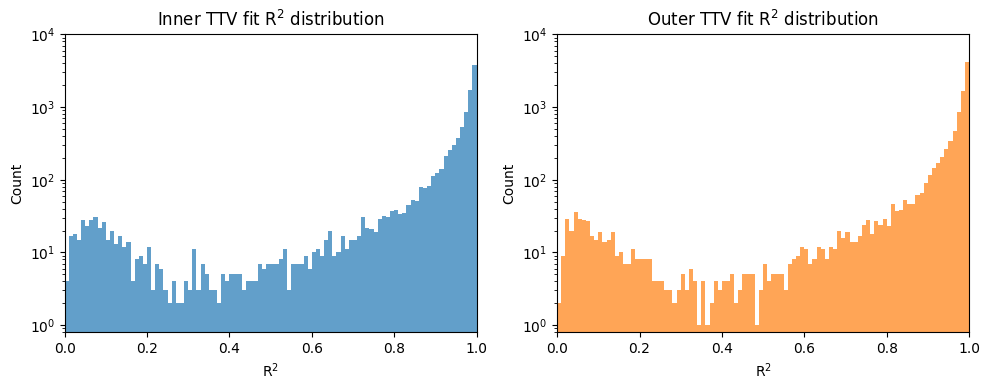

,e1,w1,e2,w2,Delta,j,P1,P2,m1,m2,...,phase1,std1,A2,B2,V2,Pttv2,phase2,std2,R2_1,R2_2
0,0.002794,303.782212,0.005116,111.941832,0.013081,4,7,9.455426,613.683372,0.516593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.003392,131.310902,0.026566,116.472256,-0.008979,3,7,10.405725,91.639422,375.153540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003647,278.084232,0.005244,249.655123,0.007424,5,7,8.814959,169.936265,112.427523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.068471,240.613521,0.067907,260.675715,-0.005708,3,7,10.440071,24.560454,2.188322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.026676,308.906024,0.004105,240.631741,0.007924,5,7,8.819331,2394.321680,1.887488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_fits.csv")
total = len(fits)

# R2-score histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(fits['R2_1'], bins=100, color='C0', alpha=0.7, range=(0, 1))
ax[0].set_title('Inner TTV fit R$^2$ distribution')

ax[1].hist(fits['R2_2'], bins=100, color='C1', alpha=0.7, range=(0, 1))
ax[1].set_title('Outer TTV fit R$^2$ distribution')

for a in ax:
    a.set_xlabel('R$^2$'); a.set_ylabel('Count')
    a.set_ylim(0.8,1e+4); a.set_xlim(0,1)
    a.set_yscale('log')

plt.tight_layout()
plt.show()

fits.head()

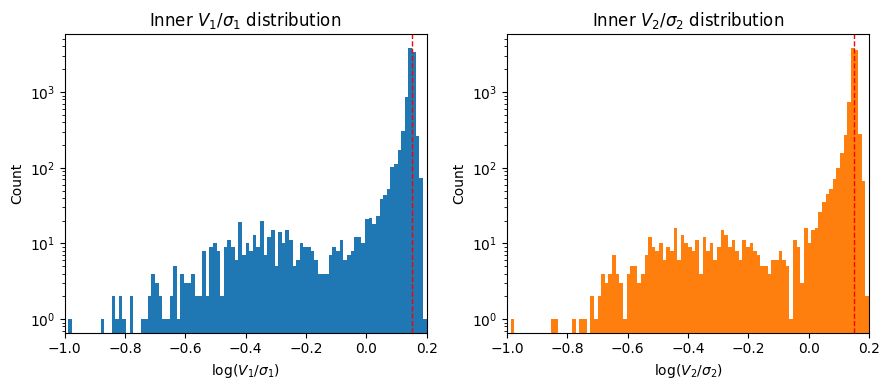

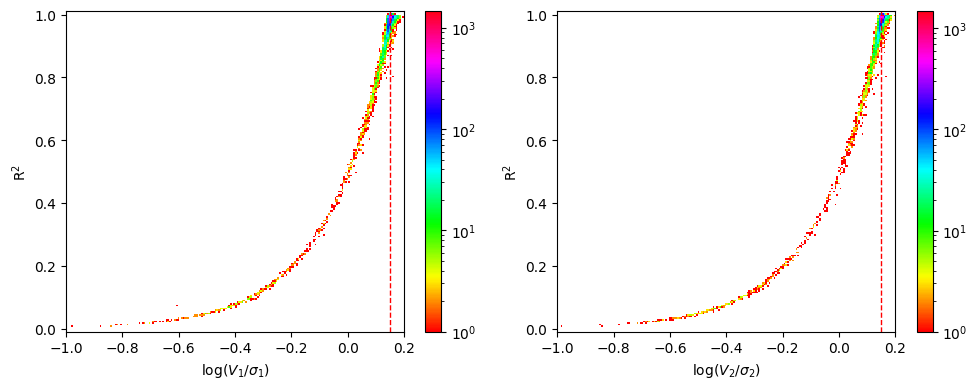

In [44]:
# Fit Amplitude / dispersion
amp_goodness1 = np.log10(np.abs(fits.V1) / fits.std1)
amp_goodness2 = np.log10(np.abs(fits.V2) / fits.std2)

# V/sigma histograms
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
rng = (-1, 0.2)
ax[0].hist(amp_goodness1, bins=100, range=rng, color='C0')
ax[1].hist(amp_goodness2, bins=100, range=rng, color='C1')

for i, a in enumerate(ax):
    a.set_title(f'Inner $V_{i+1}/\sigma_{i+1}$ distribution')
    a.set_yscale('log')
    a.set_xlim(rng)
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('Count')
    a.axvline(np.log10(np.sqrt(2)), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# V/sigma-R2 scatterplot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ax[0].scatter(amp_goodness1, fits.R2_1, s=1, color='C0')
# ax[1].scatter(amp_goodness2, fits.R2_2, s=1, color='C1')

rng = [(-1, 0.2), (-0.01, 1.01)]
h0 = ax[0].hist2d(amp_goodness1, fits.R2_1, bins=200, range=rng, norm=mcolors.LogNorm(), cmap='hsv')
h1 = ax[1].hist2d(amp_goodness2, fits.R2_2, bins=200, range=rng, norm=mcolors.LogNorm(), cmap='hsv')

plt.colorbar(h0[3], ax=ax[0])
plt.colorbar(h1[3], ax=ax[1])

for i, a in enumerate(ax):
    a.set_xlim(rng[0]), a.set_ylim(rng[1])
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('R$^2$')
    a.axvline(np.log10(np.sqrt(2)), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

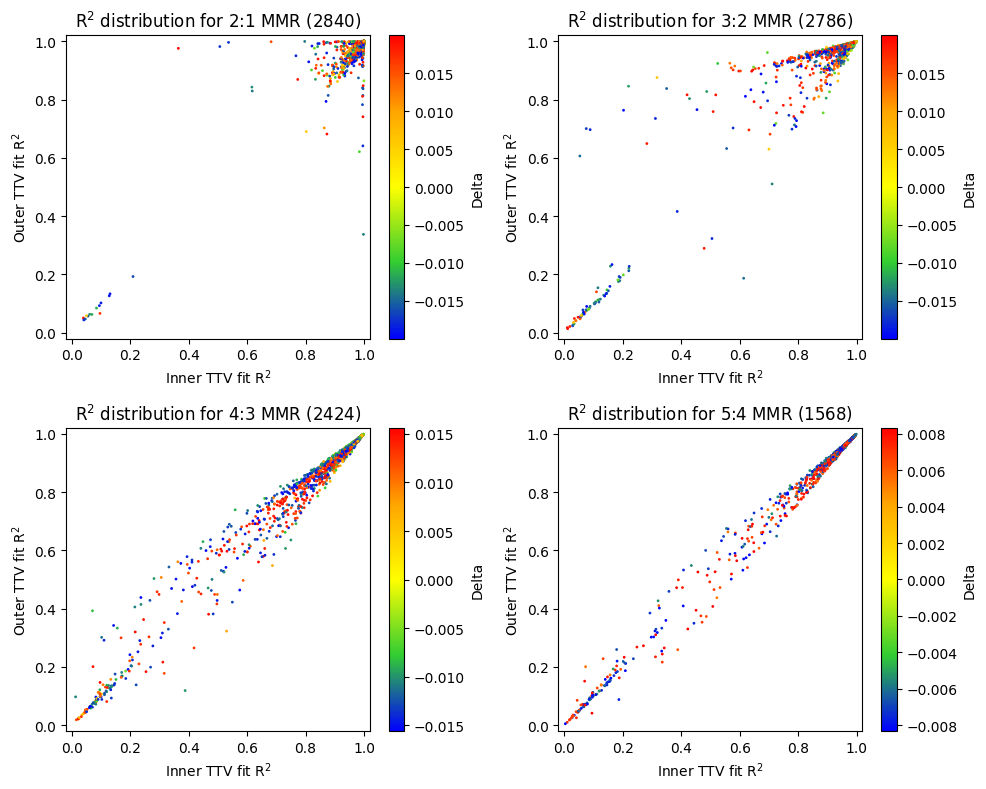

In [45]:
# R2-score scatterplots
fig, ax = plt.subplots(2, 2, figsize=(10,8))

for j, coords in zip(range(2,6), [(0,0),(0,1),(1,0),(1,1)]):
    ccol = 'Delta'  # Colormap column
    jmask = (fits.j == j) & (fits.valid == True)
    vmax = fits[ccol][jmask].max()
    vmin = fits[ccol][jmask].min()
    jtot = jmask.sum()

    # Create custom colormap: blue at vmin, yellow at 0, red at vmax
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    zero = (0 - vmin) / (vmax - vmin)
    colors = [
        (0.0, 'blue'),    # vmin
        ((0.0 + zero)/2, 'limegreen'),
        (zero, 'yellow'), # at 0
        ((1.0 + zero)/2, 'orange'),
        (1.0, 'red')      # vmax
    ]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
    
    sc = ax[coords].scatter(fits['R2_1'][jmask], fits['R2_2'][jmask], s=1,
                            c=fits[ccol][jmask], cmap=cmap)
    ax[coords].set_xlabel('Inner TTV fit R$^2$'); ax[coords].set_ylabel('Outer TTV fit R$^2$')
    ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {j}:{j-1} MMR ({jtot})')
    
    fig.colorbar(sc, ax=ax[coords], label='Delta')

plt.tight_layout()
plt.show()

In [46]:
# Filter by R2
# Minimum 10% percentile
p5_1 = np.nanpercentile(fits.R2_1, 10)
p5_2 = np.nanpercentile(fits.R2_2, 10)
print(f'Filter for R^2 (Inner TTV) and R^2 (Outer TTV): {p5_1:.3f}, {p5_2:.3f}')

R2_threshold = 0.5
R2_filter = (fits.R2_1 > p5_1) & (fits.R2_2 > p5_2)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Filter for R^2 (Inner TTV) and R^2 (Outer TTV): 0.814, 0.838
Good systems: 8696/50000 (17.39%)


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,phase1,std1,A2,B2,V2,Pttv2,phase2,std2,R2_1,R2_2
0,11,0.003351,37.979121,0.002664,67.501182,-0.008791,2,7,13.876931,14.012360,...,1.801500,0.043821,-0.004692,4.335431e-06,0.032371,837.462818,5.090886,0.022130,0.999519,0.999819
1,16,0.010611,151.612261,0.001063,185.771469,-0.011557,2,7,13.838198,5.186965,...,5.119443,0.000520,-0.000311,4.533631e-07,0.005940,593.890766,2.084435,0.004183,0.999787,0.999820
2,17,0.003174,289.823855,0.048058,18.913757,0.017704,2,7,14.247860,8.888439,...,5.690036,0.000138,0.000199,-4.637283e-08,0.005316,406.173231,2.102343,0.003767,0.943961,0.978567
3,20,0.011661,54.919729,0.058665,30.475370,0.008118,5,7,8.821030,1.150521,...,6.157067,0.013906,0.001167,-2.447569e-06,0.009527,229.335616,3.019562,0.006816,0.981368,0.980657
4,25,0.069149,143.344909,0.035053,169.271043,0.006478,5,7,8.806681,0.316334,...,4.810243,0.004048,-0.000233,9.489456e-07,0.002399,262.069413,1.662072,0.001714,0.988049,0.987753


In [47]:
# Functions, returns in %
def relerr(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3) 
    relerrs = calc[nonan]/sol[nonan]
    return relerrs

def err_gmean(calc, sol):
    relerrs = relerr(calc, sol)
    gavg = gmean(relerrs)
    return gavg

def err_med(calc, sol):
    relerrs = relerr(calc, sol)
    med = np.median(relerrs)
    return med

def err_gstd(calc, sol):
    relerrs = relerr(calc, sol)    
    logs = np.log(relerrs)
    gstd = np.exp(logs.std(ddof=0))
    return gstd

def err_1sig_percentiles(calc, sol):
    relerrs = relerr(calc, sol)
    p16 = np.percentile(relerrs, 16)
    p84 = np.percentile(relerrs, 84)
    return p16, p84

def num2dex(x):
    return np.log10(x)

def returnMetrics(df, mask='all', mode='gstd'):
    if isinstance(mask, str):
        if (mask == 'all'):
            m = np.ones(len(df), dtype=bool)
    else:
        m = mask
        
    err1 = err_gmean(df['m_calc_in'][m], df['m1'][m])
    err2 = err_gmean(df['m_calc_out'][m], df['m2'][m])
    med1 = err_med(df['m_calc_in'][m], df['m1'][m])
    med2 = err_med(df['m_calc_out'][m], df['m2'][m])

    if mode == 'gstd':
        gstd1 = err_gstd(df['m_calc_in'][m], df['m1'][m])
        gstd2 = err_gstd(df['m_calc_out'][m], df['m2'][m])
    
        MetricArr = err1, err2, med1, med2, gstd1, gstd2
        MetricArr = num2dex(MetricArr)
        
    elif mode == 'percentile':
        p16_1, p84_1 = err_1sig_percentiles(df['m_calc_in'][m], df['m1'][m])
        p16_2, p84_2 = err_1sig_percentiles(df['m_calc_out'][m], df['m2'][m])

        MetricArr = err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2
        MetricArr = num2dex(MetricArr)
        
    return MetricArr

In [48]:
# Fit line y = kx + c
def getLineFit(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3)
    x, y = sol[nonan], calc[nonan]

    # Linear fit using scipy
    slope, intercept, _, _, _ = linregress(x, y)
    return slope, intercept

# Non-nominal validation

In [49]:
# Naive validation
valid = fits['valid']
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])

for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|█████████████████████████████████████████████████████████████████████████████| 8696/8696 [00:54<00:00, 158.25it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,V2,Pttv2,phase2,std2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,11,0.003351,37.979121,0.002664,67.501182,-0.008791,2,7,13.876931,14.012360,...,0.032371,837.462818,5.090886,0.022130,0.999519,0.999819,156.738759,166.005313,43.384072,77.055800
1,16,0.010611,151.612261,0.001063,185.771469,-0.011557,2,7,13.838198,5.186965,...,0.005940,593.890766,2.084435,0.004183,0.999787,0.999820,5.187090,0.744605,8.642500,2.747594
2,17,0.003174,289.823855,0.048058,18.913757,0.017704,2,7,14.247860,8.888439,...,0.005316,406.173231,2.102343,0.003767,0.943961,0.978567,10.388475,0.921013,5.822885,0.245497
3,20,0.011661,54.919729,0.058665,30.475370,0.008118,5,7,8.821030,1.150521,...,0.009527,229.335616,3.019562,0.006816,0.981368,0.980657,1.262753,2.980804,0.972920,2.276914
4,25,0.069149,143.344909,0.035053,169.271043,0.006478,5,7,8.806681,0.316334,...,0.002399,262.069413,1.662072,0.001714,0.988049,0.987753,0.339540,0.935793,0.279166,0.759038


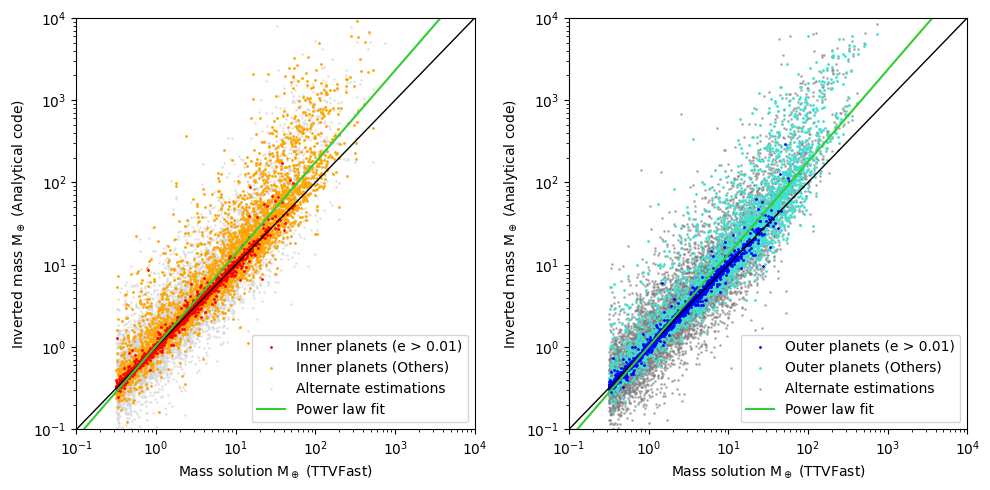

In [68]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4
linelim = np.array([minval, maxval])
scatterCount = len(compare['m1'])

ethres = 0.01
highe = (compare.e1 > ethres) & (compare.e2 > ethres); lowe = ~highe

# Inner planets
m1 = compare['m1']
m1_good = compare['m_calc_in']
m1_bad = compare['m_bad_in']
k1, c1 = getLineFit(np.log10(m1_good), np.log10(m1))

ax[0].scatter(m1[highe], m1_good[highe], s=s, color='red', label=f'Inner planets (e > 0.01)', zorder=1)
ax[0].scatter(m1[lowe], m1_good[lowe], s=s, color='orange', label=f'Inner planets (Others)', zorder=0)
ax[0].scatter(m1, m1_bad, s=s, color='lightgrey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot(linelim, linelim, color='black', lw=1, zorder=1)
ax[0].plot(linelim, 10**c1 * linelim**k1, color='limegreen', label=f'Power law fit')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
m2 = compare['m2']
m2_good = compare['m_calc_out']
m2_bad = compare['m_bad_out']
k2, c2 = getLineFit(np.log10(m2_good), np.log10(m2))

ax[1].scatter(m2[highe], m2_good[highe], s=s, color='blue', label=f'Outer planets (e > 0.01)', zorder=1)
ax[1].scatter(m2[lowe], m2_good[lowe], s=s, color='turquoise', label=f'Outer planets (Others)', zorder=0)
ax[1].scatter(m2, m2_bad, s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot(linelim, linelim, color='black', lw=1, zorder=1)
ax[1].plot(linelim, 10**c2 * linelim**k2, color='limegreen', label=f'Power law fit')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

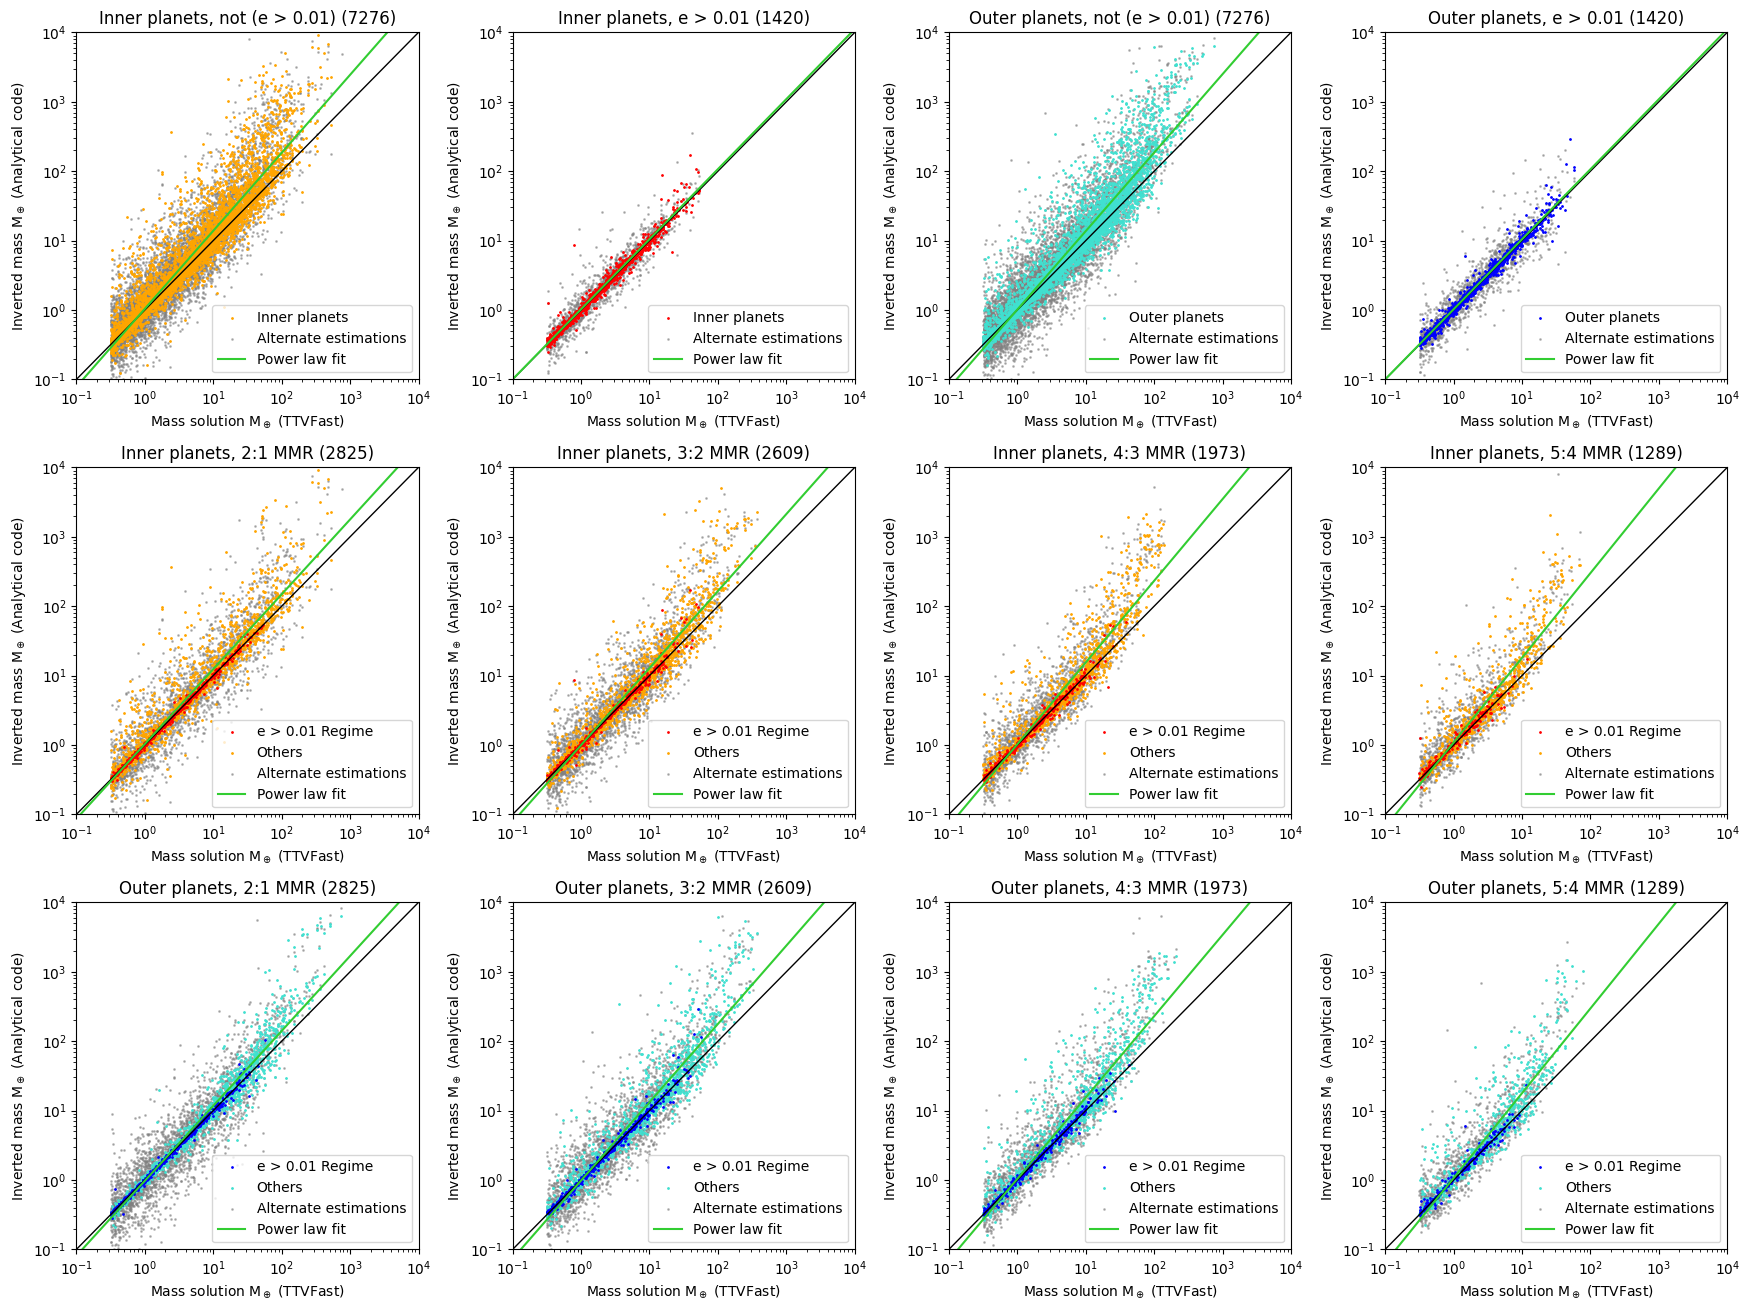

In [78]:
# Divide up by eccentricity and MMR
# Graph compare N-body outputs
fig, ax = plt.subplots(3, 4, figsize=(16*1.1, 12*1.1))

def plotMassEstimation(posTuple, x, ygood, ybad, color, innerouterStr, mask, regimeName, mode='eccentricity'):
    s = 1
    minval = 1e-1
    maxval = 1e+4
    linelim = np.array([minval, maxval])
    scatterCount = len(x[mask])
    k, c = getLineFit(np.log10(ygood[mask]), np.log10(x[mask]))


    if mode == 'eccentricity':
        ax[posTuple].scatter(x[mask], ygood[mask], s=s, color=color, label=f'{innerouterStr} planets', zorder=0)
    elif mode == 'MMR':
        ethres = 0.01
        highe = (compare.e1 > ethres) & (compare.e2 > ethres); lowe = ~highe
        
        if color == 'red':
            altcolor = 'orange'
        elif color == 'blue':
            altcolor = 'turquoise'
            
        ax[posTuple].scatter(x[mask & highe], ygood[mask & highe], s=s, color=color, label=f'e > 0.01 Regime', zorder=1)
        ax[posTuple].scatter(x[mask & lowe], ygood[mask & lowe], s=s, color=altcolor, label=f'Others', zorder=0)
    
    ax[posTuple].scatter(x[mask], ybad[mask], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
    ax[posTuple].plot(linelim, linelim, color='black', lw=1, zorder=1)
    ax[posTuple].plot(linelim, 10**c * linelim**k, color='limegreen', label=f'Power law fit')
    ax[posTuple].set_xscale('log'); ax[posTuple].set_yscale('log')
    ax[posTuple].set_xlim(minval, maxval); ax[posTuple].set_ylim(minval, maxval)
    ax[posTuple].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
    ax[posTuple].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
    ax[posTuple].legend(loc='lower right')
    ax[posTuple].set_title(f'{innerouterStr} planets, {regimeName} ({scatterCount})')

def plotMassWithRegimes(df):
    # Regime definitions
    ethres = 0.01
    highe = (compare.e1 > ethres) & (compare.e2 > ethres); lowe = ~highe
    def jmask(n): 
        return (compare.j == n)
    
    # Eccentricity
    plotMassEstimation((0,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'orange', 'Inner', lowe, 'not (e > 0.01)')
    plotMassEstimation((0,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', highe, 'e > 0.01')
    plotMassEstimation((0,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'turquoise', 'Outer', lowe, 'not (e > 0.01)')
    plotMassEstimation((0,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', highe, 'e > 0.01')
    
    # MMR
    plotMassEstimation((1,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(2), '2:1 MMR', mode='MMR')
    plotMassEstimation((1,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(3), '3:2 MMR', mode='MMR')
    plotMassEstimation((1,2), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(4), '4:3 MMR', mode='MMR')
    plotMassEstimation((1,3), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(5), '5:4 MMR', mode='MMR')
    
    plotMassEstimation((2,0), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(2), '2:1 MMR', mode='MMR')
    plotMassEstimation((2,1), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(3), '3:2 MMR', mode='MMR')
    plotMassEstimation((2,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(4), '4:3 MMR', mode='MMR')
    plotMassEstimation((2,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(5), '5:4 MMR', mode='MMR')

plotMassWithRegimes(compare)

fig.tight_layout()
plt.show()

In [87]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 0.078 dex, 0.016 dex, 0.238 dex
Geometric mean error, median error, and geometric STD (Outer): 0.070 dex, 0.014 dex, 0.219 dex


# Nominal validation

In [80]:
# Naive nominal mass validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities() for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|█████████████████████████████████████████████████████████████████████████████| 8696/8696 [00:55<00:00, 155.70it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,V2,Pttv2,phase2,std2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,11,0.003351,37.979121,0.002664,67.501182,-0.008791,2,7,13.876931,14.012360,...,0.032371,837.462818,5.090886,0.022130,0.999519,0.999819,98.144480,109.377188,90.803484,104.262801
1,16,0.010611,151.612261,0.001063,185.771469,-0.011557,2,7,13.838198,5.186965,...,0.005940,593.890766,2.084435,0.004183,0.999787,0.999820,23.132131,1.674333,25.804882,1.790513
2,17,0.003174,289.823855,0.048058,18.913757,0.017704,2,7,14.247860,8.888439,...,0.005316,406.173231,2.102343,0.003767,0.943961,0.978567,34.738675,0.689288,29.464068,0.624840
3,20,0.011661,54.919729,0.058665,30.475370,0.008118,5,7,8.821030,1.150521,...,0.009527,229.335616,3.019562,0.006816,0.981368,0.980657,11.039981,29.647086,10.243692,26.838656
4,25,0.069149,143.344909,0.035053,169.271043,0.006478,5,7,8.806681,0.316334,...,0.002399,262.069413,1.662072,0.001714,0.988049,0.987753,2.268554,7.534347,2.421873,6.905679


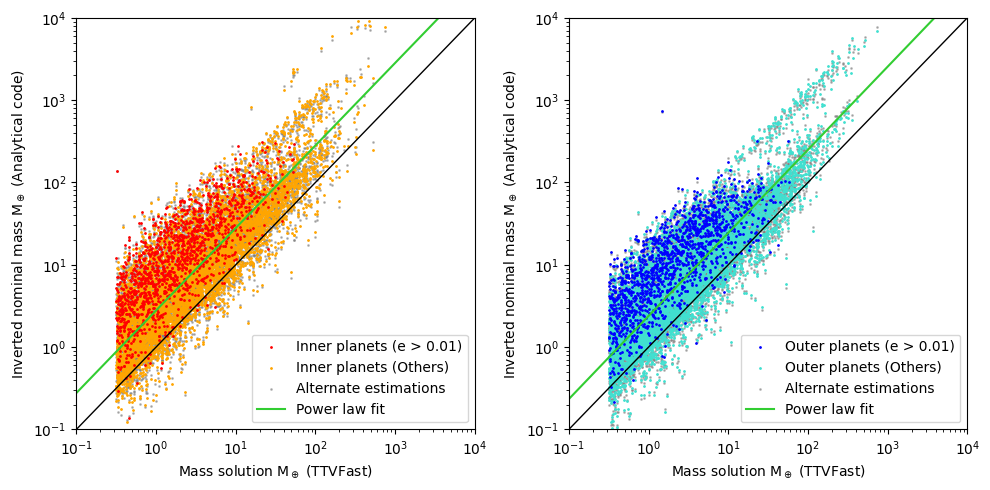

In [82]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4
linelim = np.array([minval, maxval])
scatterCount = len(compare_n['m1'])
ethres = 0.01
highe = (compare.e1 > ethres) & (compare.e2 > ethres); lowe = ~highe

# Inner planets
m1 = compare_n['m1']
m1_good = compare_n['m_calc_in']
m1_bad = compare_n['m_bad_in']
k1, c1 = getLineFit(np.log10(m1_good), np.log10(m1))

ax[0].scatter(m1[highe], m1_good[highe], s=s, color='red', label=f'Inner planets (e > 0.01)', zorder=1)
ax[0].scatter(m1[lowe], m1_good[lowe], s=s, color='orange', label=f'Inner planets (Others)', zorder=0)
ax[0].scatter(m1, m1_bad, s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot(linelim, linelim, color='black', lw=1, zorder=1)
ax[0].plot(linelim, 10**c1 * linelim**k1, color='limegreen', label=f'Power law fit')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planet
m2 = compare_n['m2']
m2_good = compare_n['m_calc_out']
m2_bad = compare_n['m_bad_out']
k2, c2 = getLineFit(np.log10(m2_good), np.log10(m2))

ax[1].scatter(m2[highe], m2_good[highe], s=s, color='blue', label=f'Outer planets (e > 0.01)', zorder=1)
ax[1].scatter(m2[lowe], m2_good[lowe], s=s, color='turquoise', label=f'Outer planets (Others)', zorder=0)
ax[1].scatter(m2, compare_n['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot(linelim, linelim, color='black', lw=1, zorder=1)
ax[1].plot(linelim, 10**c2 * linelim**k2, color='limegreen', label=f'Power law fit')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

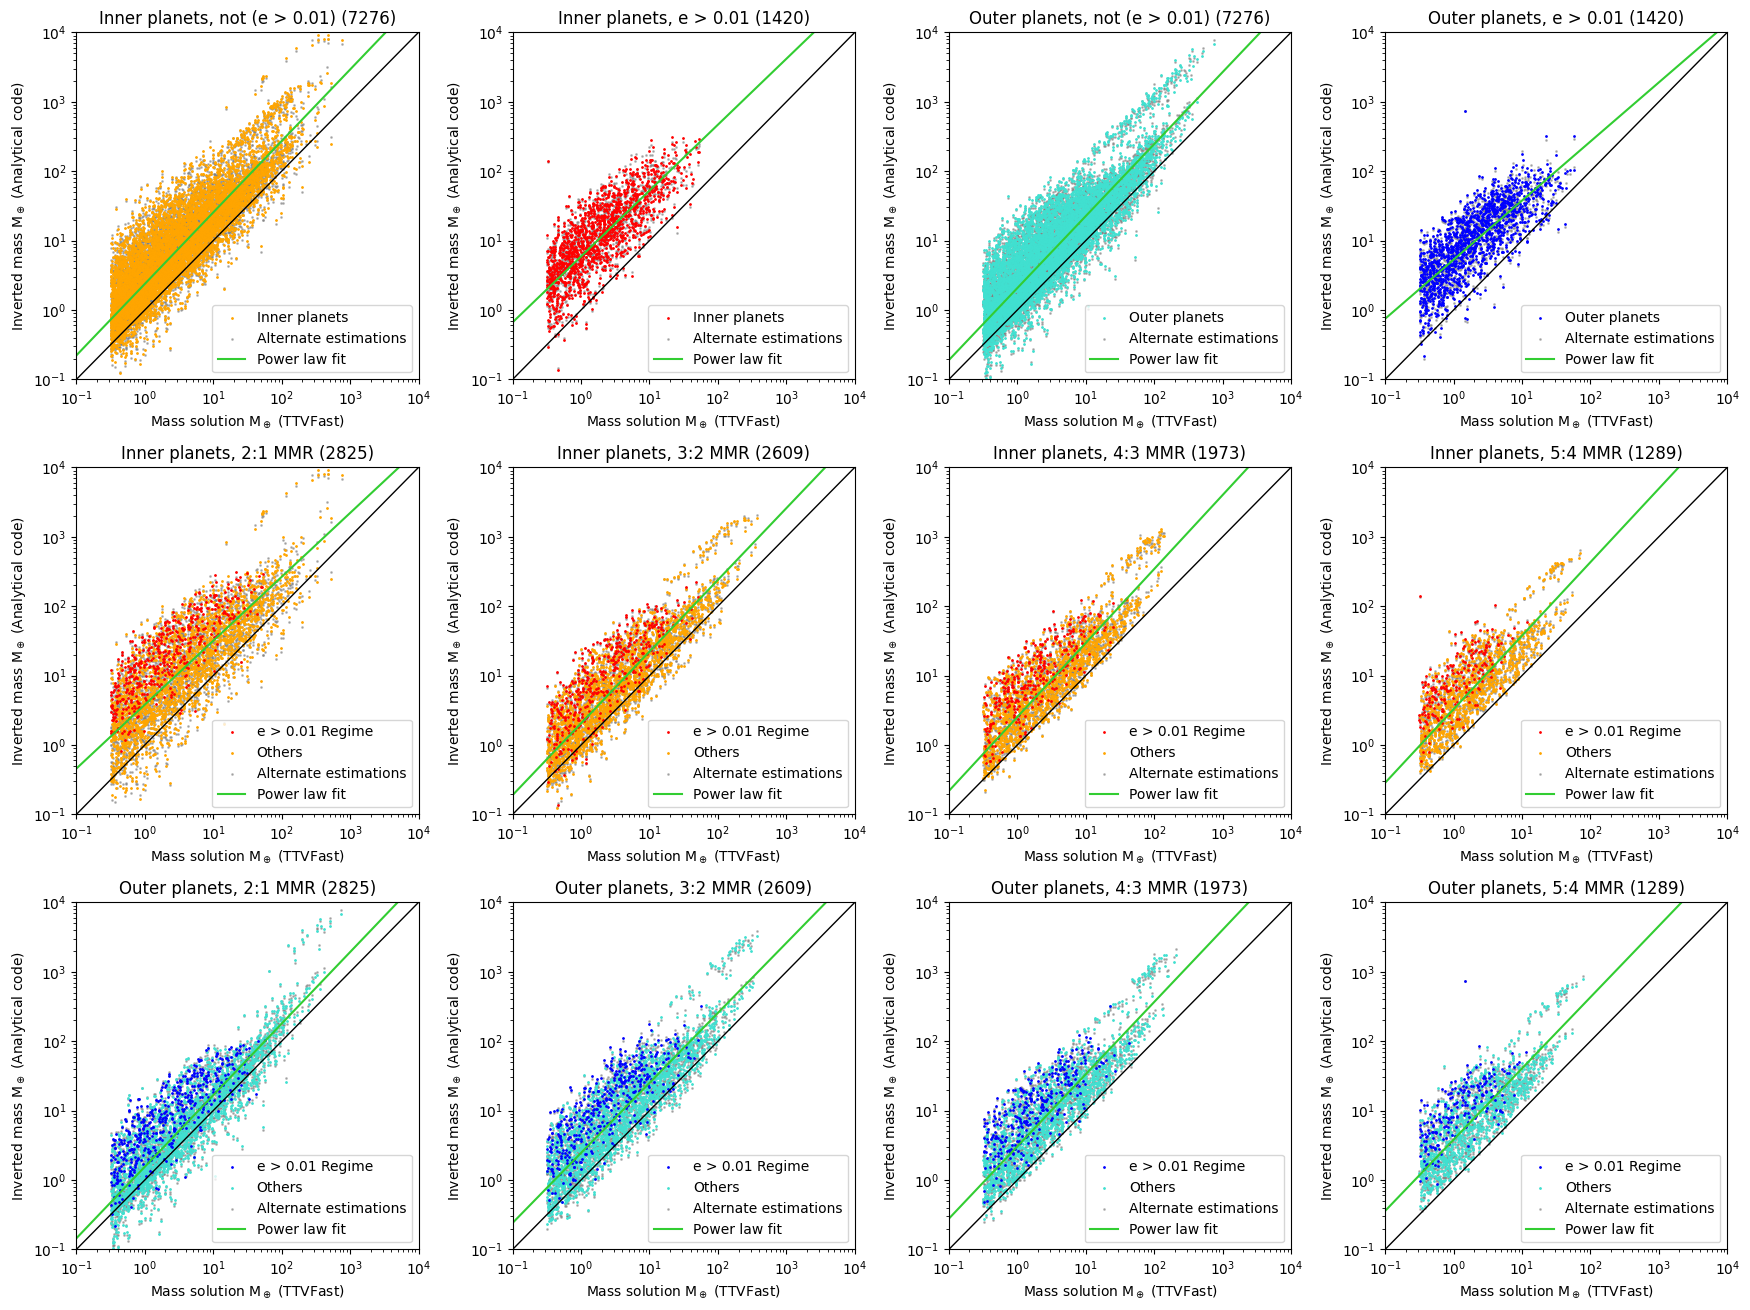

In [84]:
# Divide by regimes
fig, ax = plt.subplots(3, 4, figsize=(16*1.1, 12*1.1))
plotMassWithRegimes(compare_n)
fig.tight_layout()
plt.show()

In [97]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare_n, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 0.501 dex, 0.459 dex, 0.391 dex
Geometric mean error, median error, and geometric STD (Outer): 0.435 dex, 0.391 dex, 0.379 dex


# Metric compilation

In [132]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'p16Err', 'p16Err_n', 'p84Err', 'p84Err_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (Overall, Low e)', 'Inner (Overall, High e)',
                  'Inner (2:1 MMR, low e)', 'Inner (3:2 MMR, low e)', 'Inner (4:3 MMR, low e)', 'Inner (5:4 MMR, low e)',
                  'Inner (2:1 MMR, high e)', 'Inner (3:2 MMR, high e)', 'Inner (4:3 MMR, high e)', 'Inner (5:4 MMR, high e)',
                  'Outer (Overall)', 'Outer (Overall, Low e)', 'Outer (Overall, High e)',
                  'Outer (2:1 MMR, low e)', 'Outer (3:2 MMR, low e)', 'Outer (4:3 MMR, low e)', 'Outer (5:4 MMR, low e)',
                  'Outer (2:1 MMR, high e)', 'Outer (3:2 MMR, high e)', 'Outer (4:3 MMR, high e)', 'Outer (5:4 MMR, high e)']
metrics.head()

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,p16Err,p16Err_n,p84Err,p84Err_n
0,Inner (Overall),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Inner (Overall, Low e)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Inner (Overall, High e)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Inner (2:1 MMR, low e)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Inner (3:2 MMR, low e)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
# Regime definitions
ethres = 0.01
highe = (compare.e1 > ethres) & (compare.e2 > ethres); lowe = ~highe
def jmask(n): 
    return (compare.j == n)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2 = returnMetrics(compare, mask=m, mode='percentile')
    err1n, err2n, med1n, med2n, p16_1n, p84_1n, p16_2n, p84_2n = returnMetrics(compare_n, mask=m, mode='percentile')

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, p16_1, p16_1n, p84_1, p84_1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, p16_2, p16_2n, p84_2, p84_2n]

    count = len(compare.m1) if (isinstance(m, str) == True) else len(compare.m1[m])
    return [count, *metrics]

rows = []
for io in ['Inner', 'Outer']:
    for regime in ['all', lowe, highe,
                   *[jmask(n) & lowe for n in range(2,6)],
                   *[jmask(n) & highe for n in range(2,6)]]:
        rowi = createListToInsert(io, m=regime)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,p16Err,p16Err_n,p84Err,p84Err_n
0,Inner (Overall),8696,0.077859,0.501266,0.015703,0.458963,-0.033049,0.118435,0.1586,0.920506
1,"Inner (Overall, Low e)",7276,0.090302,0.442675,0.016902,0.400118,-0.036585,0.091992,0.204083,0.823804
2,"Inner (Overall, High e)",1420,0.014305,0.800536,0.01078,0.808598,-0.02153,0.443239,0.041363,1.156799
3,"Inner (2:1 MMR, low e)",2350,0.079425,0.498172,0.012376,0.47536,-0.035018,0.086578,0.174973,0.921345
4,"Inner (3:2 MMR, low e)",2186,0.069936,0.324497,0.012515,0.280563,-0.045888,0.009942,0.172515,0.680839
5,"Inner (4:3 MMR, low e)",1651,0.113616,0.450669,0.026147,0.391268,-0.027409,0.13037,0.241974,0.794493
6,"Inner (5:4 MMR, low e)",1089,0.119072,0.549028,0.025256,0.494176,-0.030397,0.233988,0.258961,0.917254
7,"Inner (2:1 MMR, high e)",475,0.005575,0.97188,0.00577,0.978469,-0.018391,0.660381,0.028899,1.305647
8,"Inner (3:2 MMR, high e)",423,0.017008,0.625868,0.009531,0.667519,-0.023915,0.293121,0.041012,0.958071
9,"Inner (4:3 MMR, high e)",322,0.017449,0.727813,0.017024,0.728318,-0.023949,0.41352,0.053604,1.033404


In [135]:
# Export metrics
metrics.to_csv('lithwick_code_metrics.csv', index=False)

In [138]:
# Plot visualization
inner = metrics.iloc[0:11]; outer = metrics.iloc[11:22]

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', '2:1', '3:2', '4:3', '5:4']
    ethres = 0.01
    highe = (compare.e1 > ethres) & (compare.e2 > ethres); lowe = ~highe

    df_lowe = df.iloc[[1,3,4,5,6]]
    df_highe = df.iloc[[2,7,8,9,10]]
    
    yerr_lower_l = df_lowe.MedErr - df_lowe.p16Err
    yerr_upper_l = df_lowe.p84Err - df_lowe.MedErr
    yerr_l = [yerr_lower_l, yerr_upper_l]
    
    yerrn_lower_l = df_lowe.MedErr_n - df_lowe.p16Err_n
    yerrn_upper_l = df_lowe.p84Err_n - df_lowe.MedErr_n
    yerrn_l = [yerrn_lower_l, yerrn_upper_l]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].errorbar(x=regimenames, y=df.iloc[highe_rows].MedErr, yerr=yerr_h, fmt='D', linestyle='none', color='black', zorder=1)
    ax[0].errorbar(x=regimenames, y=df.iloc[lowe_rows].MedErr, yerr=yerr_l, fmt='D', linestyle='none', color='grey', zorder=0)
    
    ax[0].set_title(f'{innerOuterStr} planet mass fractional error by regime')
    ax[0].set_ylim(top=df['p84Err'].max() * 1.15)
    ax[1].errorbar(x=regimenames, y=df.MedErr_n, yerr=yerrn, fmt='D', linestyle='none', color='grey')
    ax[1].set_title(f'{innerOuterStr} planet mass fractional error by regime (Nomimal)')
    ax[1].set_ylim(top=df['p84Err_n'].max() * 1.15)

    for i in range(5): # Text
        xpos = regimenames[i]
        s1 = 10
        s2 = 6
        
        upper = df['p84Err'].iloc[i] - df['MedErr'].iloc[i]
        lower = df['MedErr'].iloc[i] - df['p16Err'].iloc[i]
        ax[0].text(  # Left plot median + errorbar
            xpos,
            df['p84Err'].iloc[i] * 1.03,
            f'{df.MedErr.iloc[i]:.3f}',
            fontsize=s1,
            ha='right', va='bottom'
        )
        ax[0].text(
            xpos,
            df['p84Err'].iloc[i] * 1.01,
            f'+{upper:.3f}\n-{lower:.3f}',
            fontsize=s2,
            ha='left', va='bottom'
        )

        upper_n = df['p84Err_n'].iloc[i] - df['MedErr_n'].iloc[i]
        lower_n = df['MedErr_n'].iloc[i] - df['p16Err_n'].iloc[i]
        ax[1].text( # Right plot median + errorbar
            xpos,
            df['p84Err_n'].iloc[i] * 1.03,
            f'{df.MedErr_n.iloc[i]:.3f}',
            fontsize=s1,
            ha='right', va='bottom'
        )
        ax[1].text(
            xpos,
            df['p84Err_n'].iloc[i] * 1.01,
            f'+{upper_n:.3f}\n-{lower_n:.3f}',
            fontsize=s2,
            ha='left', va='bottom'
        )
    
    for a in ax:
        a.axhline(0, color='black', linestyle='--', linewidth=1)
        a.set_ylabel(f'Fractional error [dex]')
        a.set_xlabel(f'Regime ({innerOuterStr} planets)')
        a.margins(x=0.1)

    plt.show()

AttributeError: 'list' object has no attribute 'iloc'

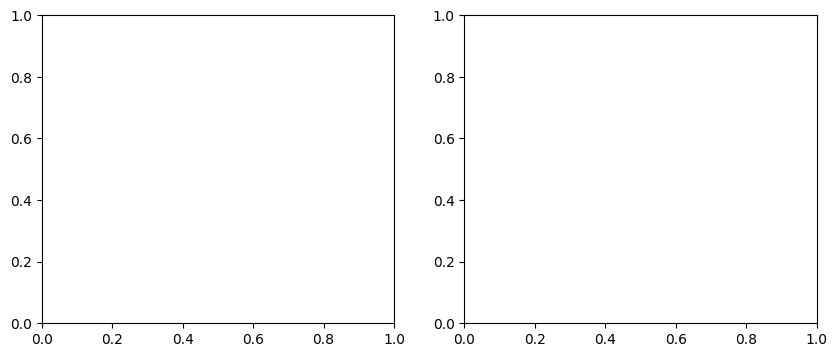

In [139]:
metricPlots(inner, 'Inner')
metricPlots(outer, 'Outer')